# Setup

In [1]:
dataType = 'fashion'
dataCol = 'Pattern'
#['Pattern', 'Collar Type', 'Fashion Trend', 'Clothing Material', 'Sleeves']

In [2]:
import os
import numpy as np
import torch
import pandas as pd
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#from pathlib import Path

MAIN_DIR=''
DATA_DIR=MAIN_DIR+'data_full/'

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Helper Functions

In [5]:
import json

def write_json(data,filename):
    print("")
    
def read_json(filename):
    if filename:
        with open(filename, 'r') as f:
            datastore = json.load(f)
    
    return datastore

In [6]:
def Process_DF(col_name, df):
    df = df.dropna(subset=[col_name])
    data=df[['itemid','title','image_path',col_name]]
    data[col_name]=data[col_name].astype('int64')
    #data = pd.get_dummies(df[col_name].astype(str),prefix=col_name,dummy_na=False)
    #data = data.iloc[:,:-1]
    #data.insert(0,'image_path',df['image_path'])
    #data.insert(0,'itemid',df['itemid'])
    return data

# Prepare Text data

In [7]:
#Define data files
files_dict={'mobile':[json_mobile,train_mobile,val_mobile],'fashion':[json_fashion,train_fashion,val_fashion],'beauty':[json_beauty,train_beauty,val_beauty]}
#files = [json_fashion,train_fashion,val_fashion]
#files = [json_mobile,train_mobile,val_mobile]
#files = [json_beauty,train_beauty,val_beauty]

In [8]:
files=files_dict[dataType]

In [9]:
import pandas as pd
#df=pd.read_csv(files[1])
df=pd.read_csv(fashion_sample)
df.head()

,Unnamed: 0,itemid,title,image_path,Pattern,Collar Type,Fashion Trend,Clothing Material,Sleeves
0,0,2282553,retro floral dress,fashion_image/78d17fdb159bba51a4250dc3d583245e,2.0,NaN,3.0,NaN,NaN
1,1,13822218,dress floral sifon,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,2.0,NaN,NaN,4.0,NaN
2,3,65755120,women s trendy apricot o neck solid chiffon bl...,fashion_image/dc9b21429604148fc0342d12694f3294,NaN,3.0,NaN,4.0,NaN
3,4,65857438,big sale baju gamis pesta india aysilla pancar...,fashion_image/6c25c578dd8edce742a805f891f1a51f,NaN,NaN,6.0,17.0,NaN
4,6,79488636,gaun mini pesta malam patchwork tanpa punggung...,fashion_image/e25977681e7ebfa815efef8087ea8fd7,5.0,8.0,6.0,NaN,3.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140316 entries, 0 to 140315
Data columns (total 9 columns):
Unnamed: 0           140316 non-null int64
itemid               140316 non-null int64
title                140316 non-null object
image_path           140316 non-null object
Pattern              82941 non-null float64
Collar Type          57453 non-null float64
Fashion Trend        79260 non-null float64
Clothing Material    89579 non-null float64
Sleeves              88433 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 9.6+ MB


In [11]:
dataframe = Process_DF(dataCol,df)
dataframe.head()

C:\Users\cwmkw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,itemid,title,image_path,Pattern
0,2282553,retro floral dress,fashion_image/78d17fdb159bba51a4250dc3d583245e,2
1,13822218,dress floral sifon,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,2
4,79488636,gaun mini pesta malam patchwork tanpa punggung...,fashion_image/e25977681e7ebfa815efef8087ea8fd7,5
5,81622997,gaun pesta kasual wanita bergaya tanpa lengan ...,fashion_image/492f80d9bdfd1e412aab0873cf172cec,1
8,109337611,dress wanita seksi kerah v lengan panjang deng...,fashion_image/6303a0eb589ea76a99af121dd3d52c58,14


# DataLoaders and Data Visualization

## Set classes

In [12]:
categories = read_json(files[0])
#print(categories.keys())
#print(categories.values())
classes=list(categories[dataCol].keys())
print(classes)

['paisley', 'plaid', 'threadwork', 'patchwork', 'plain', 'graphic', 'print', 'gingham', 'camouflage', 'polka dot', 'joint', 'wave point', 'stripe', 'knot', 'floral', 'brocade', 'cartoon', 'letter', 'check', 'embroidery']


## Set Data Loaders

In [13]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

class NDSCDataset(Dataset):

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe : Dataframe with id, image_path and target column
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.target = dataframe.iloc[:,[-1]]
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx,2])+'.jpg'
        #image = io.imread(img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        
        itemid = self.dataframe.iloc[idx,0]
        target = self.dataframe.iloc[idx,-1]
        title = self.dataframe.iloc[idx,1]
        #target=torch.from_numpy(target)
        #target = target.astype('float').reshape(-1, 2)
        sample = {'image': image, 'target': target,'title': title,'itemid':itemid}

        
        return sample

# VGG-16 Takes 224x224 images as input, so we resize all of them
image_transform = transforms.Compose([transforms.Resize((224,224)),
                                      #transforms.RandomResizedCrop(224,scale=(0.8,1.0)),
                                      transforms.ToTensor()
                                     ])

In [14]:
# define dataloader parameters
batch_size = 20
num_workers=0

dataset = NDSCDataset(dataframe=dataframe, root_dir=DATA_DIR,transform=image_transform)

In [15]:
len(dataset)

82941

In [16]:
validation_split = 0.2
shuffle_dataset = True
random_seed= 42

from torch.utils.data.sampler import SubsetRandomSampler

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=num_workers, sampler=valid_sampler)
#data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [17]:
print(len(train_loader),len(test_loader))

3318 830


## Visualise some sample data

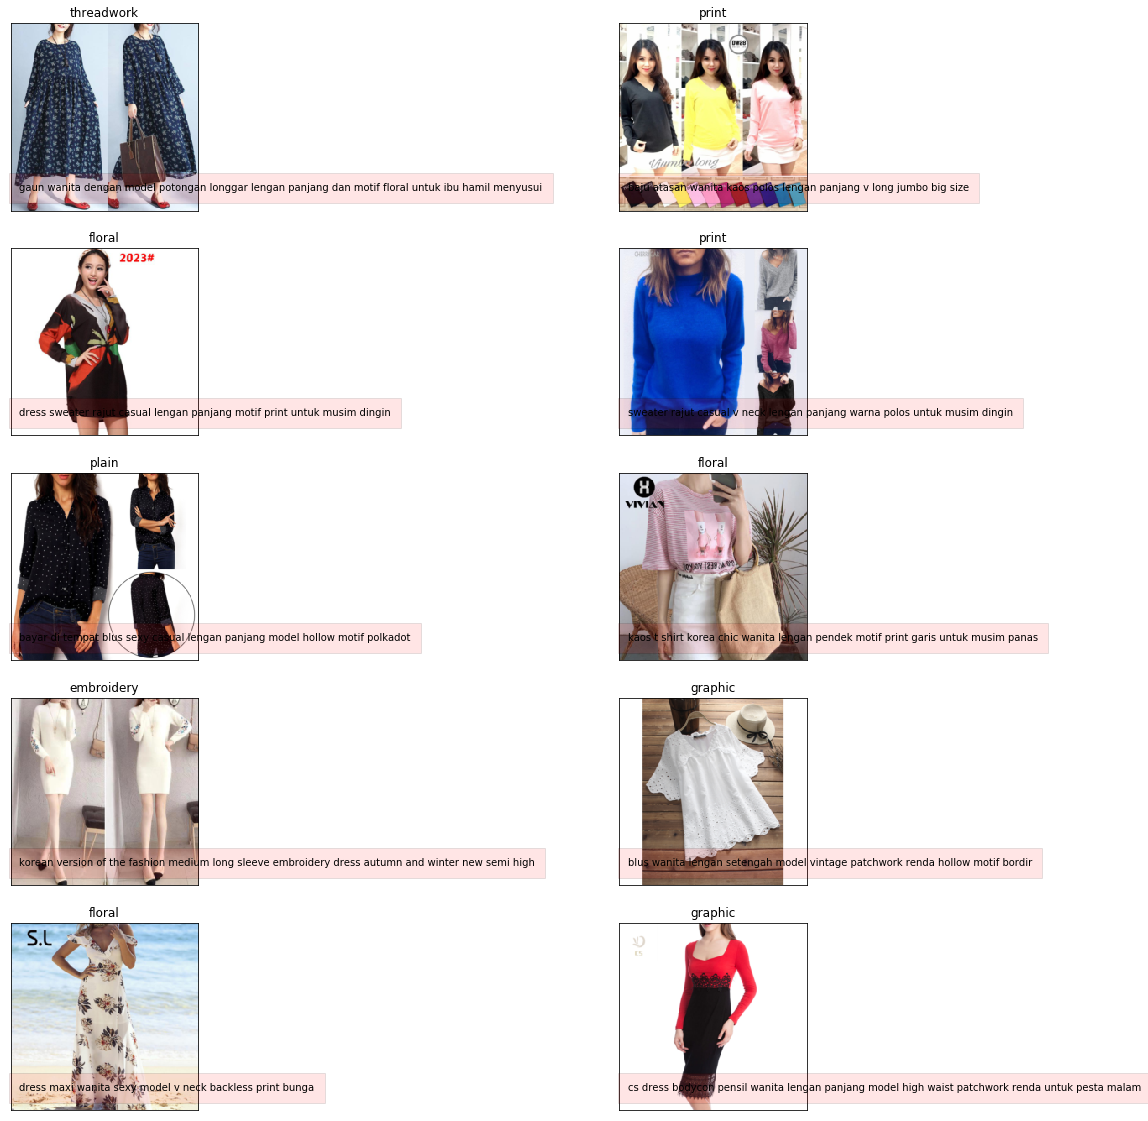

In [18]:
# obtain one batch of training images
dataiter = iter(train_loader)
sample_batched= dataiter.next()
#print(i_batch)
#print(sample_batched['image'])
#print(sample_batched['target'])
images = sample_batched['image'].numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
for idx in np.arange(10):
    ax = fig.add_subplot(5, 10/5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    #print(sample_batched['target'][idx].item())
    ax.set_title(classes[int(sample_batched['target'][idx].item())])
    ax.text(10,200,sample_batched['title'][idx],fontsize=10,bbox={'facecolor':'red', 'alpha':0.1, 'pad':10})

---
# Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [19]:
# Load the pretrained model from pytorch
#model = models.vgg16(pretrained=True)
model = models.vgg16()

# print out the model structure
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [24]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = True

### Define final layer

In [21]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features

last_layer = nn.Linear(n_inputs,len(classes))

model.classifier[6] = last_layer

# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()
    
print(model.classifier[6].out_features)

20


## Resnet50

In [35]:
from torchvision import models

# Load the pretrained model from pytorch
model = models.resnet50()

# print out the model structure
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [40]:
import torch.nn as nn

n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs,len(classes))

model.fc = last_layer

# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()
    
print(model.fc.out_features)

20


## Model Summary

In [25]:
!pip install torchsummary
from torchsummary import summary

print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Specify Loss Function and Optimizer

In [26]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training

In [27]:
# number of epochs to train the model
n_epochs = 20
train_loss_min = 100

from pathlib import Path

for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    i=0
    for sample in train_loader:
        i+=1
        #print(i)
        # move tensors to GPU if CUDA is available
        data = sample['image']
        target = sample['target']
        title = sample['title']
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()#*data.size(0)
    
        if i % 100 == 99:    # print training loss every specified number of mini-batches
            if epoch>1 and train_loss < train_loss_min:
                train_loss_min = train_loss
                path=Path(MAIN_DIR+'results/'+dataType+'_'+dataCol+'_state_epoch'+str(epoch)+'_batch_'+str(i))
                torch.save(model.state_dict(), path)
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 100 loss: 14.5398924827575691
Epoch 1, Batch 200 loss: 13.9719616413116459
Epoch 1, Batch 300 loss: 13.0765997529029843
Epoch 1, Batch 400 loss: 12.2235156893730164
Epoch 1, Batch 500 loss: 11.5666042625904080
Epoch 1, Batch 600 loss: 11.2674647390842431
Epoch 1, Batch 700 loss: 10.9240621030330658
Epoch 1, Batch 800 loss: 10.8489242315292351
Epoch 1, Batch 900 loss: 10.9177358150482178
Epoch 1, Batch 1000 loss: 10.6549938678741452
Epoch 1, Batch 1100 loss: 10.6390053331851959
Epoch 1, Batch 1200 loss: 10.7153226852416985
Epoch 1, Batch 1300 loss: 10.6933519780635837
Epoch 1, Batch 1400 loss: 10.5226342022418979
Epoch 1, Batch 1500 loss: 10.7693857073783867
Epoch 1, Batch 1600 loss: 10.5187143623828891
Epoch 1, Batch 1700 loss: 10.6054534077644345
Epoch 1, Batch 1800 loss: 10.6957622289657586
Epoch 1, Batch 1900 loss: 10.6603817880153660
Epoch 1, Batch 2000 loss: 10.5193674921989437
Epoch 1, Batch 2100 loss: 10.5531507790088650
Epoch 1, Batch 2200 loss: 10.42329074740409

Epoch 11, Batch 2700 loss: 10.3750700831413276
Epoch 11, Batch 2800 loss: 10.5465742230415351
Epoch 11, Batch 2900 loss: 10.1919691979885094
Epoch 11, Batch 3000 loss: 10.4971533358097080
Epoch 11, Batch 3100 loss: 10.3373046636581414
Epoch 11, Batch 3200 loss: 10.5383610904216773
Epoch 11, Batch 3300 loss: 10.1922201395034797
Epoch 12, Batch 100 loss: 10.6455383121967309
Epoch 12, Batch 200 loss: 10.4357453167438514
Epoch 12, Batch 300 loss: 10.2385427772998803
Epoch 12, Batch 400 loss: 10.5527886211872097
Epoch 12, Batch 500 loss: 10.2985739052295688
Epoch 12, Batch 600 loss: 10.5121955454349525
Epoch 12, Batch 700 loss: 10.4498633384704593
Epoch 12, Batch 800 loss: 10.4820377945899956
Epoch 12, Batch 900 loss: 10.4449530482292179
Epoch 12, Batch 1000 loss: 10.5314303517341621
Epoch 12, Batch 1100 loss: 10.3581197142601020
Epoch 12, Batch 1200 loss: 10.2492571771144867
Epoch 12, Batch 1300 loss: 10.4508147418499000
Epoch 12, Batch 1400 loss: 10.4415950536727902
Epoch 12, Batch 1500 l

KeyboardInterrupt: 

In [49]:
torch.cuda.empty_cache()

## Save full model

In [28]:
from pathlib import Path
path=Path(MAIN_DIR+'results/'+dataType+'_'+dataCol+'full_model_epoch'+str(n_epochs))
torch.save(model, path)

### Load model

In [36]:
from pathlib import Path
path=Path(MAIN_DIR+'results/'+dataType+'_'+dataCol+'_epoch'+'7')
model=torch.load(path, map_location='cpu')
model.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.vgg.VGG' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Save state_dict

In [47]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [43]:
n_epochs=5
from pathlib import Path
path=Path(MAIN_DIR+'results/'+dataType+'_'+dataCol+'_state_epoch'+str(n_epochs))
torch.save(model.state_dict(), path)

### Load state_dict

In [50]:
model = models.model()
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs,len(classes))
model.classifier[6] = last_layer

model.load_state_dict(torch.load(path))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [52]:
from torchsummary import summary
print(summary(model, (3, 224, 224)))

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:201

## Save General Checkpoint

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)

In [ ]:
model = models.model()
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs,len(classes))
model.classifier[6] = last_layer

optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

# Testing

In [44]:
# track test loss over all classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval() # eval mode

# iterate over test data
for sample in test_loader:
    data = sample['image']
    target = sample['target']
    title = sample['title']
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i < len(target):
            label = target[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: ', (test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss:  0.25107740105463977
Test Accuracy of paisley:  0% ( 0/ 8)
Test Accuracy of plaid: 49% (141/284)
Test Accuracy of threadwork: 37% (707/1879)
Test Accuracy of patchwork:  0% ( 1/192)
Test Accuracy of plain:  0% ( 0/50)
Test Accuracy of graphic: 32% (272/829)
Test Accuracy of print: 81% (3879/4734)
Test Accuracy of gingham:  0% ( 0/11)
Test Accuracy of camouflage: 27% ( 9/33)
Test Accuracy of polka dot: 37% (44/117)
Test Accuracy of joint:  0% ( 0/ 5)
Test Accuracy of wave point:  0% ( 0/17)
Test Accuracy of stripe: 68% (918/1350)
Test Accuracy of  knot:  0% ( 0/75)
Test Accuracy of floral: 68% (2521/3672)
Test Accuracy of brocade: 71% (977/1374)
Test Accuracy of cartoon:  1% ( 2/144)
Test Accuracy of letter:  5% ( 9/174)
Test Accuracy of check: 35% (455/1288)
Test Accuracy of embroidery:  9% (34/352)

Test Accuracy (Overall): 60% (9969/16588)


## Visualize Sample Test Results

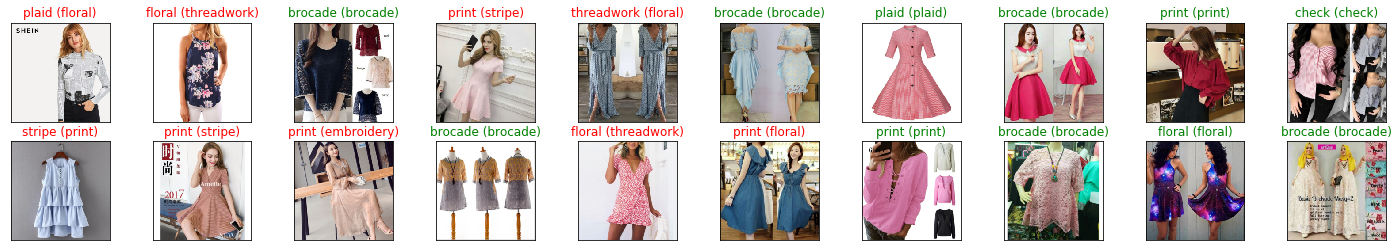

In [45]:
# obtain one batch of test images
dataiter = iter(test_loader)
sample_batched= dataiter.next()
images = sample_batched['image']
labels = sample_batched['target']
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images=images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Validate

In [34]:
df2=pd.read_csv(files[2])
#val_dataframe = Process_DF(dataCol,df2)
#val_dataframe.head()
df2.head()

,itemid,title,image_path
0,381034175,fashion wanita cardigan drape terbuka lengan p...,new_fashion_image/9ba6bf09ae89c2b9069faf569e7a...
1,396355150,bayar di tempat fashion wanita fg sweater hood...,new_fashion_image/f465cd2e55352e3ed9ab49b16257...
2,592583745,bayar di tempat cardigan sweater model lengan ...,new_fashion_image/18d709b8be0d8385689bbf5e0ab2...
3,721929368,blazer lengan panjang slim warna polos dengan ...,new_fashion_image/5c861844f6e497f0a56b8e37138c...
4,800794259,sweater rajut longgar lengan panjang warna polos,new_fashion_image/13fbe2dcbaa567939acf708d6d8e...


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69498 entries, 0 to 69497
Data columns (total 3 columns):
itemid        69498 non-null int64
title         69498 non-null object
image_path    69498 non-null object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [36]:
df2.image_path[0][:-3]

'new_fashion_image/9ba6bf09ae89c2b9069faf569e7a5131.'

In [37]:
df2.image_path = [file[:-4] for file in df2.image_path]

In [38]:
df2.image_path[0]

'new_fashion_image/9ba6bf09ae89c2b9069faf569e7a5131'

In [39]:
#batch_size = 50

dataset = NDSCDataset(dataframe=df2, root_dir=DATA_DIR,transform=image_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [40]:
len(data_loader)

3475

In [100]:
# track test loss over all classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval() # eval mode

outputDF = pd.DataFrame(columns=['itemid',dataCol,dataCol,dataCol])

# iterate over test data
for num, sample in enumerate(data_loader):
    print(num)
    itemid = sample['itemid']
    data = sample['image']
    title = sample['title']
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data = data.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # convert output probabilities to predicted class
    _, pred = torch.topk(output, 3) 
    
    temp = pd.DataFrame(pred.data.numpy(),columns=[dataCol,dataCol,dataCol])
    temp['itemid'] = itemid
    temp = temp[['itemid',dataCol]]
    outputDF=outputDF.append(temp)
    outputDF.to_csv(MAIN_DIR+'results/'+dataType+' '+dataCol+'.csv',index=False)

0
1
2
3
4
5


PermissionError: [Errno 13] Permission denied: 'fashion Fashion Trend.csv'

# END

In [69]:
# obtain one batch of test images
dataiter = iter(train_loader)
sample_batched= dataiter.next()
itemid = sample_batched['itemid']
images = sample_batched['image']
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
_, pred = torch.topk(output, 3)    

In [101]:
outputDF.to_csv(MAIN_DIR+'results/'+dataType+' '+dataCol+'.csv',index=False)

In [89]:
temp = pd.DataFrame(pred.data.numpy(),columns=[dataCol,dataCol,dataCol])
temp['itemid'] = itemid
temp = temp[['itemid',dataCol]]
output

,itemid,Fashion Trend,Fashion Trend,Fashion Trend
0,790330669,7,4,3
1,1780964461,7,0,6
2,1032577085,8,9,7
3,1370505422,8,9,10
4,242730758,7,9,10
5,1307535486,9,10,6
6,1322390152,3,6,0
7,1602293297,8,9,2
8,729754859,3,0,6
9,474372458,10,4,1


In [91]:
output=output.append(output)
output

,itemid,Fashion Trend,Fashion Trend,Fashion Trend
0,790330669,7,4,3
1,1780964461,7,0,6
2,1032577085,8,9,7
3,1370505422,8,9,10
4,242730758,7,9,10
5,1307535486,9,10,6
6,1322390152,3,6,0
7,1602293297,8,9,2
8,729754859,3,0,6
9,474372458,10,4,1


In [74]:
np.concatenate((itemid,pred))

ValueError: all the input arrays must have same number of dimensions

In [ ]:
for i_batch,sample_batched in enumerate(data_loader,0):
    print("training sample for mnist-m")
    print(i_batch,sample_batched['image'],sample_batched['target'])

In [ ]:
for i in range(5):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['target'].shape)
    print(sample['image'])
    print(sample['target'])

In [ ]:
sample['target']